In [1]:
using Distributions
using StatsBase
using PyPlot

# アヒル本4章のデータ
x=Real[ 24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52,  56,  56,  57,  58,  59,  59]
y=Real[472,403,454,575,546,781,750,601,814,792,745,837,868,988,1092,1007,1233,1202,1123,1314]

20-element Array{Real,1}:
  472
  403
  454
  575
  546
  781
  750
  601
  814
  792
  745
  837
  868
  988
 1092
 1007
 1233
 1202
 1123
 1314

In [2]:
function likelihood(a, b, sigma)
    y_pred = a + b*x
    likelihoods = [logpdf(Normal(aa, sigma), bb) for (aa,bb) in zip(y_pred,y)]
    l_sum = sum(likelihoods)
    return l_sum
end

function dlikelihood(a, b, sigma)
    y_pred = a + b*x
    
    grad_a    = sum(y - y_pred)/sigma^2
    grad_b    = dot(x, y - y_pred)/sigma^2
    grad_sigma= -1.0/sigma * length(x) + sum(abs2,y - y_pred)/sigma^3
    return [grad_a, grad_b, grad_sigma]
end

function Leapfrog(theta, r, epsilon)
    r += 0.5 * epsilon * dlikelihood(theta[1], theta[2], theta[3])
    theta +=   epsilon * r
    r += 0.5 * epsilon * dlikelihood(theta[1], theta[2], theta[3])
    return theta, r
end

function Hamiltonian(theta, r)
    return -likelihood(theta[1], theta[2], theta[3]) + (0.5 * sum(abs2,r))
end

Hamiltonian (generic function with 1 method)

In [3]:
#HMC法
# a, b, sigmaの初期値; Chain 1つ分
Init = Real[-80.0, 20.0, 50] 
push!(Init, Hamiltonian(Init,[0,0,0]))
Iteration = 50000
BurnIn    = 2000
chain = Array[Init]

T = 100
epsilon = 0.2

for i in 1:Iteration
    r = [rand(Normal(0, 1)) for x in 1:3]
      
    proposal_draw = chain[i][1:3]
    proposal_r    = r
        
    for t in 1:T
        proposal_draw, proposal_r = Leapfrog(proposal_draw, proposal_r, epsilon)
    end
    
    tmp1  = Hamiltonian(proposal_draw, proposal_r)
    tmp2  = Hamiltonian(chain[i], r)

    alpha = min(1,exp(tmp2-tmp1))   
    u = rand(Uniform(0,1))
    if mod(i, 500)==1
        println((i, proposal_draw, alpha))
    end
    if u < alpha
        push!(proposal_draw, Hamiltonian(proposal_draw,[0,0,0]))
        push!(chain, proposal_draw)
    else
        push!(chain, chain[i])
    end
end

# BurnInは除外
chain = chain[BurnIn+1:end]

# 結果の取り出し
a = [chain[i][1] for i in 1:length(chain)]
b = [chain[i][2] for i in 1:length(chain)]
sigma = [chain[i][3] for i in 1:length(chain)]

println("MCMC complete")

(1, [-101.942, 20.4781, 109.929], 1.0)
(501, [-75.2822, 21.2751, 84.2512], 0.9983129510984269)
(1001, [-236.058, 25.1137, 104.93], 0.9881894703251234)
(1501, [-203.94, 23.8522, 73.7174], 1.0)
(2001, [-195.692, 23.7633, 88.4793], 0.9611198482374561)
(2501, [-116.486, 22.9902, 83.1214], 0.8128727270043841)
(3001, [-79.376, 21.3009, 83.574], 1.0)
(3501, [-116.148, 22.034, 100.218], 1.0)
(4001, [-53.7866, 20.7243, 74.3022], 0.9986189233831795)
(4501, [-92.8998, 21.1629, 116.663], 0.9981243324399104)
(5001, [-185.428, 23.2544, 86.7362], 1.0)
(5501, [-86.9643, 21.572, 67.0522], 0.9989171677160705)
(6001, [-91.0031, 21.9895, 99.0907], 0.9893120546315423)
(6501, [-54.0317, 20.4726, 67.3258], 1.0)
(7001, [-141.042, 22.0386, 71.0273], 0.98024765248764)
(7501, [19.6244, 19.8603, 104.785], 0.9550448014286794)
(8001, [-147.428, 22.1194, 76.4303], 1.0)
(8501, [-105.471, 22.2604, 93.3496], 0.9657629585368017)
(9001, [-185.98, 23.6526, 66.4354], 1.0)
(9501, [-89.6145, 21.0491, 65.5244], 0.991457932219

In [4]:
mean(a),mean(b),mean(sigma)

(-118.01782085753437, 21.8688140862139, 85.37220546731278)

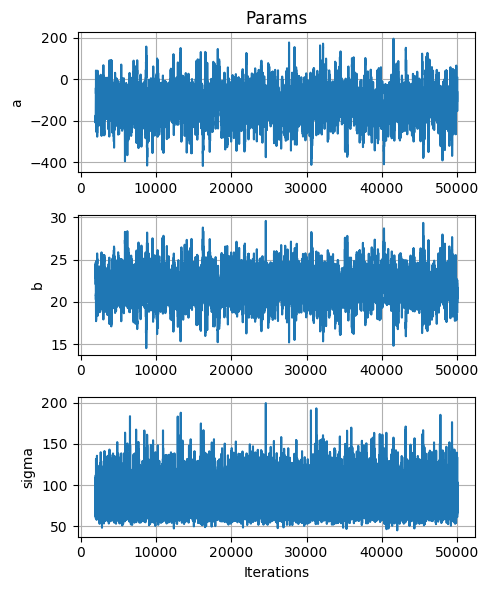

In [5]:
# Plot 
fig = figure(figsize=(5,6))
ax = fig[:add_subplot](3,1,1)

iterations=BurnIn:Iteration

plot(iterations,a)
ylabel("a")
title("Params")
grid("on")

ax = fig[:add_subplot](3,1,2)
plot(iterations,b)
ylabel("b")
grid("on")

ax = fig[:add_subplot](3,1,3)
plot(iterations,sigma)
xlabel("Iterations")
ylabel("sigma")
grid("on")

tight_layout()

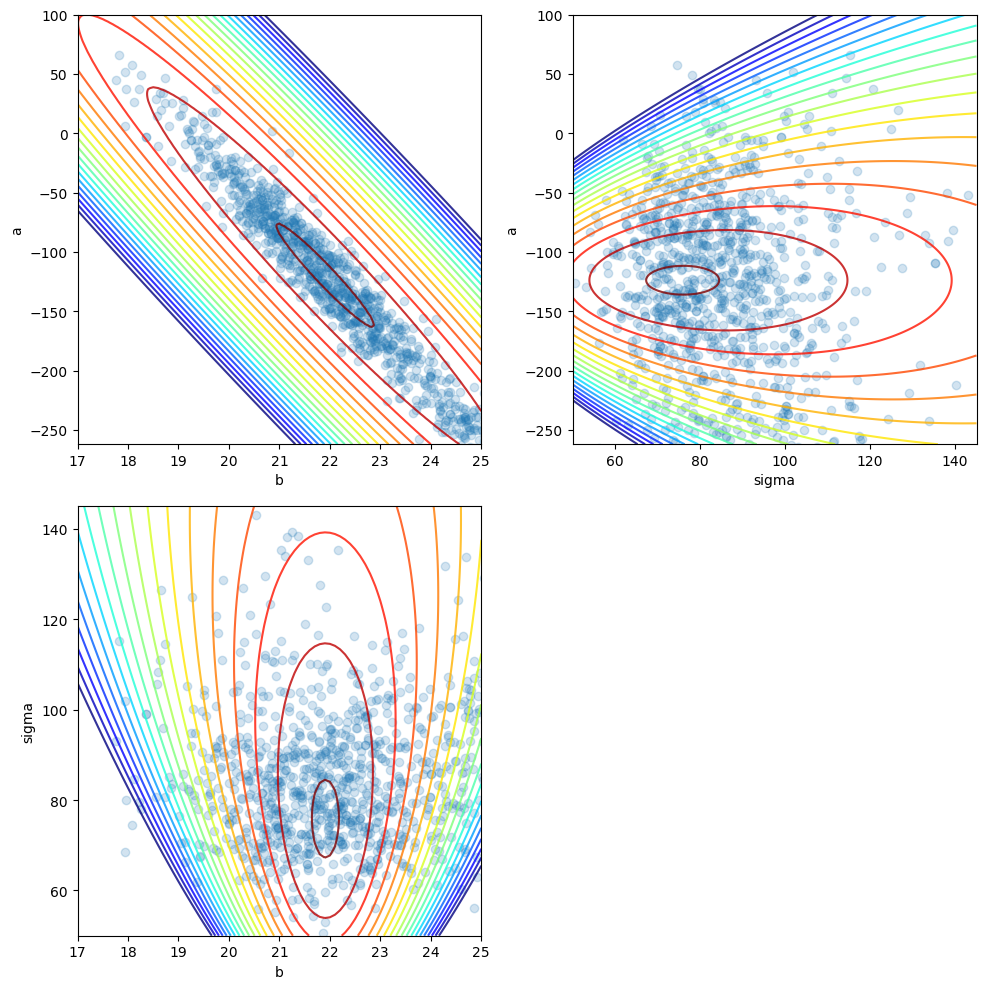

In [6]:
_a = -120.0
_b = 22.0
_sigma = 79.0

a_list = collect(-262:100)
b_list = collect(17:0.1:25)
sigma_list = collect(50:145)

ab_list = [likelihood(tmp_a,tmp_b,_sigma) for tmp_a in a_list, tmp_b in b_list]
ac_list = [likelihood(tmp_a,_b,    tmp_sigma) for tmp_a in a_list, tmp_sigma in sigma_list]
cb_list = [likelihood(_a, tmp_b,tmp_sigma) for tmp_sigma in sigma_list, tmp_b in b_list]

levels = collect(-160:2.5:-115)

# 結果の取り出し
sample_size = maximum([length(a)-1000,0]):length(a)

a = a[sample_size]
b = b[sample_size]
sigma = sigma[sample_size]

# Plot 
fig = figure(figsize=(10,10))
ax = fig[:add_subplot](2,2,1)

b_grid = repmat(b_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(b_list))

cp = ax[:contour](b_grid,a_grid, ab_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,a,alpha=0.2)
xlabel("b")
ylabel("a")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(222)
ax = fig[:add_subplot](2,2,2)

c_grid = repmat(sigma_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(sigma_list))

cp = ax[:contour](c_grid,a_grid, ac_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(sigma,a,alpha=0.2)
xlabel("sigma")
ylabel("a")
ax[:set_xlim]([sigma_list[1],sigma_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(223)
ax = fig[:add_subplot](2,2,3)

b_grid = repmat(b_list',length(sigma_list),1)
c_grid = repmat(sigma_list, 1, length(b_list))

cp = ax[:contour](b_grid,c_grid, cb_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,sigma,alpha=0.2)
xlabel("b")
ylabel("sigma")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([sigma_list[1],sigma_list[end]])
tight_layout()

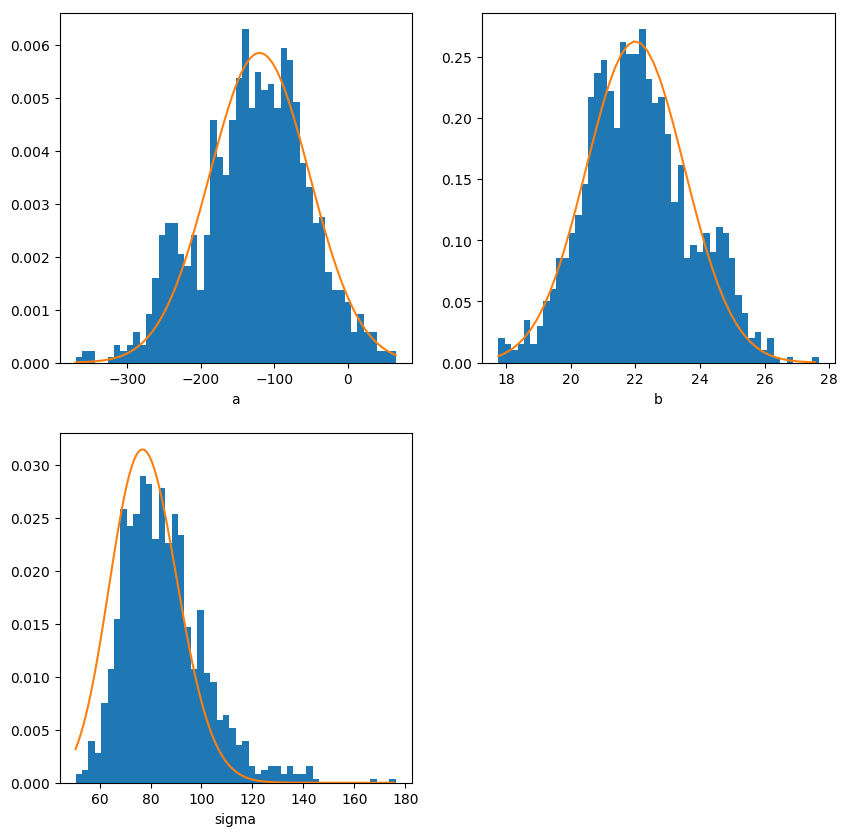

PyObject <matplotlib.text.Text object at 0x00000000265A4780>

In [10]:
fig = figure("pyplot_histogram",figsize=(10,10))

ax = fig[:add_subplot](2,2,1)
h = plt[:hist](a,50, normed=true)
plottyx = collect(minimum(a):maximum(a))
plot(plottyx, pdf.(Normal(_a,68.15),plottyx))
xlabel("a")

ax = fig[:add_subplot](2,2,2)
h = plt[:hist](b,50, normed=true)
plottyx = collect(minimum(b):0.2:maximum(b))
plot(plottyx, pdf.(Normal(_b,1.52),plottyx))
xlabel("b")

ax = fig[:add_subplot](2,2,3)
h = plt[:hist](sigma,50, normed=true)
plottyx = collect(minimum(sigma):maximum(sigma))
plot(plottyx, pdf.(Chi(18),plottyx/(79.1/sqrt(18)))/18)
xlabel("sigma")